<a href="https://colab.research.google.com/github/sungjuGit/STPython_IntroBayes/blob/main/Multilevel_Reedfrogs_pymc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Converted from the Julia code by Claude.ai

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
from scipy.stats import norm, binom
from scipy.special import expit as logistic

In [ ]:
# Set the random seed
np.random.seed(1)

# Define constants and generate mock data
a_bar = 1.5
sigma = 1.5
nponds = 60
Ni = np.repeat([3, 10, 25, 35], 15)  # repeat each value 15 times

# Generate "true" data
a_pond = norm.rvs(loc=a_bar, scale=sigma, size=nponds)

# Create DataFrame
dsim = pd.DataFrame({
    'pond': np.arange(1, nponds + 1),
    'Ni': Ni,
    'true_a': a_pond
})

# Calculate true probabilities
dsim['true_p'] = logistic(dsim['true_a'])

# Generate binomial random variables for survival counts
dsim['Si'] = np.array([binom.rvs(n=n, p=p) for n, p in zip(dsim['Ni'], dsim['true_p'])])

# Calculate observed proportions
dsim['p_sim'] = dsim['Si'] / dsim['Ni']

# Define PyMC models

## No pooling (single-level model)

In [ ]:
def pond_single_level(Si, Ni):
    with pm.Model() as model:
        a_pond = pm.Normal('a_pond', mu=0, sigma=1.5, shape=len(Ni))

        # Likelihood
        p = pm.Deterministic('p', pm.math.sigmoid(a_pond))
        pm.Binomial('Si', n=Ni, p=p, observed=Si)

        # Sample
        trace = pm.sample(1000, random_seed=1, return_inferencedata=True)

    return trace

## Partial pooling using the multi-level model

In [ ]:
def pond_multi_level(Si, Ni):
    with pm.Model() as model:
        sigma = pm.Exponential('sigma', 1)
        a_bar = pm.Normal('a_bar', mu=0, sigma=1.5)

        a_pond = pm.Normal('a_pond', mu=a_bar, sigma=sigma, shape=len(Ni))

        # Likelihood
        p = pm.Deterministic('p', pm.math.sigmoid(a_pond))
        pm.Binomial('Si', n=Ni, p=p, observed=Si)

        # Sample
        trace = pm.sample(1000, random_seed=1, return_inferencedata=True)

    return trace

# Analysis

In [ ]:
# Sample from the models
pond_single_level_trace = pond_single_level(dsim['Si'].values, dsim['Ni'].values)
pond_multi_level_trace = pond_multi_level(dsim['Si'].values, dsim['Ni'].values)



Output()

Output()

In [ ]:
pond_single_level_trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [ ]:
pond_multi_level_trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [ ]:
az.summary(pond_single_level_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_pond[0],1.510,1.093,-0.477,3.574,0.015,0.031,5544.0,1499.0,1.0
a_pond[1],0.511,1.029,-1.293,2.523,0.016,0.025,3917.0,1582.0,1.0
a_pond[2],1.513,1.021,-0.387,3.427,0.017,0.025,3907.0,1487.0,1.0
a_pond[3],1.550,1.071,-0.501,3.531,0.018,0.027,3503.0,1462.0,1.0
a_pond[4],1.517,1.060,-0.321,3.603,0.016,0.028,4676.0,1459.0,1.0
...,...,...,...,...,...,...,...,...,...
p[55],0.911,0.043,0.827,0.977,0.001,0.001,3738.0,1212.0,1.0
p[56],0.860,0.054,0.757,0.947,0.001,0.001,3506.0,1285.0,1.0
p[57],0.886,0.051,0.791,0.970,0.001,0.001,4004.0,1537.0,1.0
p[58],0.835,0.061,0.728,0.945,0.001,0.002,4050.0,1363.0,1.0


In [ ]:
sample_size = pond_single_level_trace.posterior["a_pond"].shape[1]

# Calculate predicted probabilities
dsim['p_nopool'] = [
    np.mean(logistic(pond_single_level_trace.posterior["a_pond"].values[0,0:sample_size-1,i]))
    for i in range(nponds)
]

dsim['p_partpool'] = [
    np.mean(logistic(pond_multi_level_trace.posterior["a_pond"].values[0,0:sample_size-1,i]))
    for i in range(nponds)
]

# Calculate errors
dsim['nopool_error'] = np.abs(dsim['p_nopool'] - dsim['true_p'])
dsim['partpool_error'] = np.abs(dsim['p_partpool'] - dsim['true_p'])



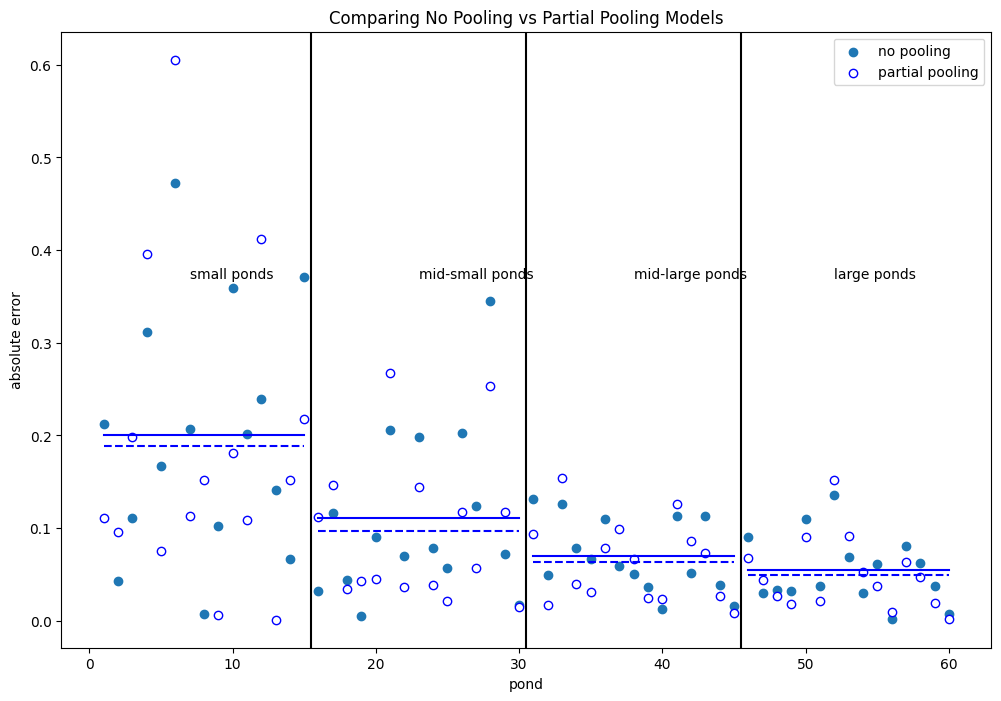

In [ ]:
# Create visualization
plt.figure(figsize=(12, 8))
plt.scatter(dsim['pond'], dsim['nopool_error'], label='no pooling')
plt.scatter(dsim['pond'], dsim['partpool_error'], facecolor='white', edgecolor='blue', label='partial pooling')

# Add vertical lines and annotations
for line in [15.5, 30.5, 45.5]:
    plt.axvline(x=line, color='black')

annotations = [
    (7, 0.37, "small ponds"),
    (16+7, 0.37, "mid-small ponds"),
    (31+7, 0.37, "mid-large ponds"),
    (45+7, 0.37, "large ponds")
]

for x, y, text in annotations:
    plt.annotate(text, (x, y), fontsize=10)

# Group results by number of tadpoles
grouped = dsim.groupby('Ni')
pools = grouped.agg({
    'nopool_error': 'mean',
    'partpool_error': 'mean',
    'pond': ['min', 'max']
})
pools.columns = ['nopool_error_mean', 'partpool_error_mean', 'pond_minimum', 'pond_maximum']
pools = pools.reset_index()

# Add horizontal lines for group means
for i in range(len(pools)):
    plt.plot(
        [pools.loc[i, 'pond_minimum'], pools.loc[i, 'pond_maximum']],
        [pools.loc[i, 'nopool_error_mean'], pools.loc[i, 'nopool_error_mean']],
        'b-'
    )
    plt.plot(
        [pools.loc[i, 'pond_minimum'], pools.loc[i, 'pond_maximum']],
        [pools.loc[i, 'partpool_error_mean'], pools.loc[i, 'partpool_error_mean']],
        'b--'
    )

plt.xlabel('pond')
plt.ylabel('absolute error')
plt.legend()
plt.title('Comparing No Pooling vs Partial Pooling Models')
plt.show()